In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn import set_config
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import f_regression, f_classif, mutual_info_classif, chi2, SelectKBest
set_config(display='diagram')

## **Read data from UCI dataset**

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv', sep=',')
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [3]:
df.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

After reviewing, we have made decision on the feature of `Revenue` as our targets to research in this campain.

In [4]:
df['Revenue'].value_counts()

False    10422
True      1908
Name: Revenue, dtype: int64

Below, we would refer to split the data set into train set and test set with ratio of (75%, 25%) of data set. Moreover, from the train set, we continue spliting a part of it for validation set with ratio of (75%, 25%) of train set.

In [5]:
df, test_df = train_test_split(df, test_size=0.25, random_state=0)
train_df, val_df = train_test_split(df, test_size=0.25, random_state=0)

In [6]:
print(f"Train set shape: {train_df.shape}")
print(f"Validate set shape: {val_df.shape}")
print(f"Test set shape: {test_df.shape}")

Train set shape: (6935, 18)
Validate set shape: (2312, 18)
Test set shape: (3083, 18)


We just `randome_state` the `train_test_split` to make the training process more efficient in general.

In [7]:
train_df.head().index

Int64Index([3271, 10384, 5126, 6650, 11485], dtype='int64')

In [8]:
train_df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
3271,7,89.900000,3,84.0,58,2787.250000,0.000000,0.007716,98.042626,0.0,May,2,2,1,2,Returning_Visitor,False,False
10384,9,137.322222,1,418.5,41,1933.244444,0.006079,0.021222,0.000000,0.0,Dec,2,2,1,2,Returning_Visitor,False,False
5126,0,0.000000,0,0.0,43,703.833333,0.000000,0.006977,0.000000,0.0,May,2,4,1,2,Returning_Visitor,False,False
6650,1,20.200000,0,0.0,77,3107.173333,0.002597,0.017042,18.748602,0.0,Sep,2,2,7,1,Returning_Visitor,False,True
11485,0,0.000000,0,0.0,30,1285.166667,0.002759,0.022660,0.000000,0.0,Nov,3,3,1,8,Returning_Visitor,True,False


In [9]:
cate_cols = train_df.columns[-8:]
nume_cols = train_df.columns.drop(cate_cols)

### Identify outliers

In [10]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,9247.000000,9247.000000,9247.000000,9247.000000,9247.000000,9247.000000,9247.000000,9247.000000,9247.000000,9247.000000,9247.000000,9247.000000,9247.000000,9247.000000
mean,2.317725,82.191815,0.499513,33.715256,31.792149,1194.550816,0.022387,0.043220,5.783374,0.061815,2.127501,2.362388,3.164161,4.094950
std,3.310203,182.657364,1.275052,140.574715,44.871329,1961.423881,0.048841,0.048798,18.258968,0.199509,0.922164,1.718090,2.411012,4.051937
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,180.500000,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,8.000000,0.000000,0.000000,18.000000,588.366667,0.002985,0.025421,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,94.000000,0.000000,0.000000,38.000000,1473.495833,0.017058,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,360.953384,1.000000,8.000000,13.000000,9.000000,20.000000


* Interquartile Range Method

In [11]:
Q1 = train_df[nume_cols].quantile(0.25)
Q3 = train_df[nume_cols].quantile(0.75)
IQR = Q3 - Q1

outlier_iqr_df = train_df[~((train_df[nume_cols] < (Q1 - 1.5 * IQR)) | (train_df[nume_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
print(f'Percentage of outliers: {round((1-outlier_iqr_df.shape[0]/train_df.shape[0])*100, 2)}%')

Percentage of outliers: 56.41%


This method made us surprised that the outliers claim too high percentage so we need to visualize them

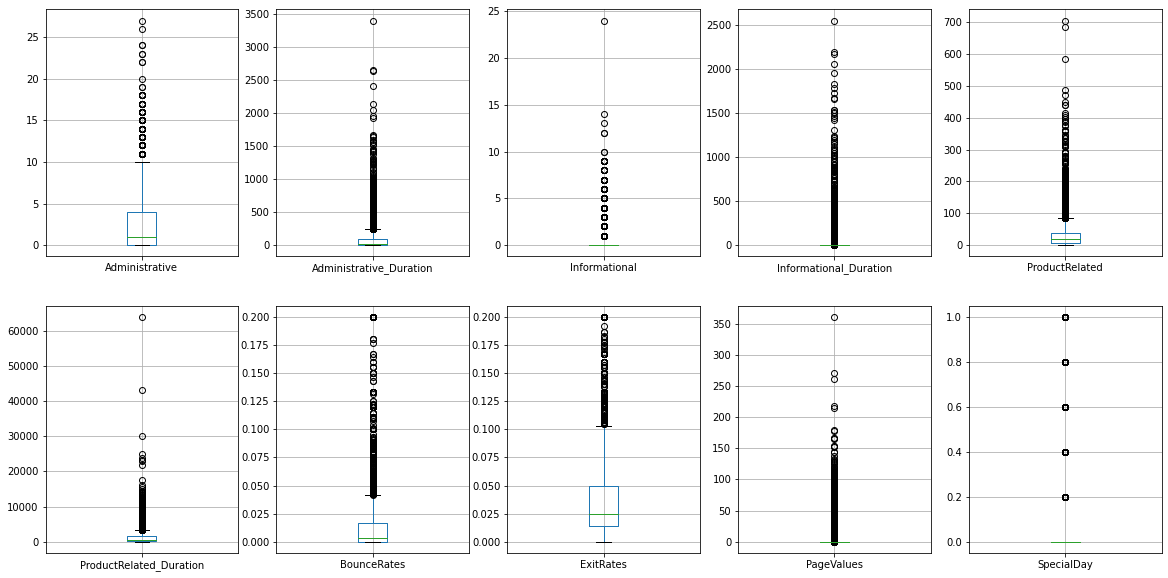

In [12]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for index in range(len(nume_cols)):
    row, col = index // 5, index % 5
    train_df.boxplot(nume_cols[index], ax = axes[row, col], fontsize=10) 
plt.show()

Look at the graph, we can see that each numerical column contains too many outliers that we can not remove them because it can affect the result

In [13]:
data_mean, data_std = np.mean(train_df[nume_cols], axis=0), np.std(train_df[nume_cols])
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
outlier_std_df = train_df[~((train_df[nume_cols] < lower) | (train_df[nume_cols] > upper)).any(axis=1)]
print(f'Percentage of outliers: {round((1-outlier_std_df.shape[0]/train_df.shape[0])*100, 2)}%')

Percentage of outliers: 18.59%


The percentage of outliers is so high that we wonder whether the values are outliers. We intend to use another method so as to handle.

In [14]:
lof = LocalOutlierFactor()
yhat = lof.fit_predict(train_df[nume_cols])
mask = yhat != -1
outlier_aod_df = train_df.iloc[mask]
print(f'Percentage of outliers: {round((1-outlier_aod_df.shape[0]/train_df.shape[0])*100, 2)}%')

Percentage of outliers: 9.52%


<b>We can see that there are too many outliers existed in the dataset. We wonder whether they have their own meaning so we decide to ignore them.</b>

### d) Check duplicates

In [15]:
duplicates = train_df.shape[0] - train_df.drop_duplicates().shape[0]
print(f'There are {duplicates} duplicate(s) in the train set and it claims {round(duplicates*100/train_df.shape[0],2)}%')

There are 48 duplicate(s) in the train set and it claims 0.69%


The dataset contains some duplicates so we decide to remove them

In [16]:
train_df.drop_duplicates(inplace=True)

### e) Check category columns

In [17]:
for col in cate_cols:
    print(f'{col}: {train_df[col].unique()}')

Month: ['May' 'Dec' 'Sep' 'Nov' 'Mar' 'June' 'Jul' 'Oct' 'Aug' 'Feb']
OperatingSystems: [2 3 1 4 8 6 5 7]
Browser: [ 2  4  3  1  6  5 10 13  8  7 12 11  9]
Region: [1 7 6 8 4 3 9 2 5]
TrafficType: [ 2  1  8  4  6  3 13 20  5 11  7 10 15  9 14 19 12 18 16]
VisitorType: ['Returning_Visitor' 'New_Visitor' 'Other']
Weekend: [False  True]
Revenue: [False  True]


After checking by hand, we see that the data is quite correct so we do not need to repair.
In order to handle conveniently, we will encode which columns are not number to number later 

# Task 2: Feature Engineering

To find the correlation of each features, we should encode the object values to number in order to handle

In [18]:
encode_df = train_df.copy()
LE = LabelEncoder()
obj_cols = train_df.select_dtypes(['bool', 'object'])
for col in obj_cols:
    encode_df[col] = LE.fit_transform(encode_df[col])
encode_df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
3271,7,89.900000,3,84.0,58,2787.250000,0.000000,0.007716,98.042626,0.0,6,2,2,1,2,2,0,0
10384,9,137.322222,1,418.5,41,1933.244444,0.006079,0.021222,0.000000,0.0,1,2,2,1,2,2,0,0
5126,0,0.000000,0,0.0,43,703.833333,0.000000,0.006977,0.000000,0.0,6,2,4,1,2,2,0,0
6650,1,20.200000,0,0.0,77,3107.173333,0.002597,0.017042,18.748602,0.0,9,2,2,7,1,2,0,1
11485,0,0.000000,0,0.0,30,1285.166667,0.002759,0.022660,0.000000,0.0,7,3,3,1,8,2,1,0


In [19]:
encode_df.shape

(6887, 18)

In [20]:
best_features = SelectKBest(score_func=chi2, k=7)
X = encode_df.drop(['Revenue'], axis=1)
y = encode_df['Revenue']
fit = best_features.fit(X, y)
scores_df = pd.DataFrame(fit.scores_)
columns_df = pd.DataFrame(X.columns)
featureScores = pd.concat([columns_df, scores_df],axis=1)
featureScores.columns = ['Feature', 'Score']
print(featureScores.nlargest(10, 'Score'))

                    Feature          Score
5   ProductRelated_Duration  471437.755664
8                PageValues   95348.280205
1   Administrative_Duration   30451.873728
3    Informational_Duration   15668.826600
4            ProductRelated   10431.320555
0            Administrative     635.007361
2             Informational     189.924354
10                    Month      42.441125
9                SpecialDay      32.747646
15              VisitorType      26.170121


<p>We assume that top 7 most correlative with Revenue column will be appropriate for the model.</p>

# Data Modelling

In [21]:
train_X_df = train_df.drop(['Revenue'], axis=1)
train_y_sr = train_df['Revenue']
val_X_df = val_df.drop(['Revenue'], axis=1)
val_y_sr = val_df['Revenue']
test_X_df = test_df.drop(['Revenue'], axis=1)
test_y_sr = test_df['Revenue']
cate_cols = cate_cols.drop(['Revenue'])

In [22]:
class ColAdderDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_list=[], num_top_values_list=[], default=-1):
        self.num_top_values_list = num_top_values_list
        self.columns_list = columns_list
        self.default = default

    def getLogicNumberTopValue(self, X_df, column):
        counts = X_df[column].value_counts()
        return sum([1 for value in list(counts.values) if value>(1*max(list(counts.values))/100)])

    def reprocessing_data(self, X_df):
        self.columns_list = [column for column in self.columns_list if len(X_df[column].value_counts())>=5]
        if len(self.num_top_values_list)==0:
            self.num_top_values_list = [self.getLogicNumberTopValue(X_df, column) for column in self.columns_list]

    def fit(self, X_df, y=None):
        self.reprocessing_data(X_df)
        self.top_values_list = []

        for column, num_top_values in zip(self.columns_list, self.num_top_values_list):
            self.counts_ = X_df[column].value_counts()
            ids = list(self.counts_.index)
            self.top_values_list.append(ids[:max(1, min(num_top_values, len(ids)))])
        return self
    
    def transform(self, X_df, y=None):
        out_df = X_df.copy()
        for top_value, column in zip(self.top_values_list, self.columns_list):
            out_df.loc[~out_df[column].isin(top_value), column] = self.default
            out_df = out_df.sort_index(axis=1)
        return out_df

<p>Some category columns have too many categories that will affect the model. So, we choose which columns that have more than 5 categories to process</p>

In [23]:
col_adderdropper = ColAdderDropper(columns_list=cate_cols)
col_adderdropper.fit(train_X_df)
new_train_X_df = col_adderdropper.transform(train_X_df)
new_train_X_df.head()

,Administrative,Administrative_Duration,BounceRates,Browser,ExitRates,Informational,Informational_Duration,Month,OperatingSystems,PageValues,ProductRelated,ProductRelated_Duration,Region,SpecialDay,TrafficType,VisitorType,Weekend
3271,7,89.900000,0.000000,2,0.007716,3,84.0,May,2,98.042626,58,2787.250000,1,0.0,2,Returning_Visitor,False
10384,9,137.322222,0.006079,2,0.021222,1,418.5,Dec,2,0.000000,41,1933.244444,1,0.0,2,Returning_Visitor,False
5126,0,0.000000,0.000000,4,0.006977,0,0.0,May,2,0.000000,43,703.833333,1,0.0,2,Returning_Visitor,False
6650,1,20.200000,0.002597,2,0.017042,0,0.0,Sep,2,18.748602,77,3107.173333,7,0.0,1,Returning_Visitor,False
11485,0,0.000000,0.002759,3,0.022660,0,0.0,Nov,3,0.000000,30,1285.166667,1,0.0,8,Returning_Visitor,True


<h3>Preprocessing Pipeline</h3>

- `Preprocessing`: in here, input data would be treated by seperating into numeric and categorical data. After spliting, both of them would be fill up **Missing Values** with the MEAN for the numeric and MOST_FREQUENCY for categorical. In addition, categorical would be encoding by `OneHotEncoder`.

In [24]:
numerics_trans = SimpleImputer()
categorical_trans=make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

column_trans = make_column_transformer(
    (numerics_trans, nume_cols),
    (categorical_trans, cate_cols)
)

preprocess_pipeline = make_pipeline(col_adderdropper, column_trans, StandardScaler(with_mean=False))
preprocess_train_X = preprocess_pipeline.fit_transform(train_X_df)
preprocess_pipeline

Pipeline(steps=[('coladderdropper',
                 ColAdderDropper(columns_list=['Month', 'OperatingSystems',
                                               'Browser', 'Region',
                                               'TrafficType'],
                                 num_top_values_list=[10, 5, 8, 9, 11])),
                ('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(),
                                                  Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRel...
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay'],
      dtype='object')),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType',
       'VisitorType', 'Weekend'],
      dtype='object'))])),
                ('standardscaler', StandardScaler(with_mean=False))])

<h3>1st Model: Classification using Neural Network</h3>

Problem: With the given features, detecting the crucial ones then build up modeling for the classification of these features into Revenue-Rewards

Pipline architecture: Along including Preprocessing Pipeline, there are 2 more:
- `Selecting Best Features`: in this step, data would filtered in order to reduce the dimension of data by using `Chi2-Algorithms`. The number of features kept would be defined by manually or by grid search later.
- `MLP Classifier`: using Neural Network method, this step would start to learning through the preprocessed data and spride out the ACCURACY of this model after training.

In [25]:
full_pipeline = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('selectkbest', SelectKBest(chi2, k=10)),
    ('mlpclassifier', MLPClassifier(hidden_layer_sizes=(50), activation='relu', solver='adam', random_state=0, learning_rate_init=0.05, alpha=100, max_iter=1000))
])
full_pipeline

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('coladderdropper',
                                  ColAdderDropper(columns_list=['Month',
                                                                'OperatingSystems',
                                                                'Browser',
                                                                'Region',
                                                                'TrafficType'],
                                                  num_top_values_list=[10, 5, 8,
                                                                       9,
                                                                       11])),
                                 ('columntransformer',
                                  ColumnTransformer(transformers=[('simpleimputer',
                                                                   SimpleImputer(),
                                                                   Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Infor...
                                                                   Index(['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType',
       'VisitorType', 'Weekend'],
      dtype='object'))])),
                                 ('standardscaler',
                                  StandardScaler(with_mean=False))])),
                ('selectkbest',
                 SelectKBest(score_func=<function chi2 at 0x000002F9A20F27A0>)),
                ('mlpclassifier',
                 MLPClassifier(alpha=100, hidden_layer_sizes=50,
                               learning_rate_init=0.05, max_iter=1000,
                               random_state=0))])

In [26]:
full_pipeline.fit(train_X_df, train_y_sr)
train_acc = full_pipeline.score(train_X_df, train_y_sr)*100
val_acc = full_pipeline.score(val_X_df, val_y_sr)*100
print(f'With the above model pipeline we get the accuracy of train: {train_acc.round(3)} and validate: {val_acc.round(3)}')

With the above model pipeline we get the accuracy of train: 84.275 and validate: 86.981


Due to the defined paramaters of Neural Network, in which include `hidden_layer_sizes=(50), activation='relu', solver='adam', random_state=0, learning_rate_init=0.05, alpha=100, max_iter=1000`, we got the final accuracy was: **84.523%**

After training the model we got the accuracy is 84.5%, this score still be pretty unacceptable so in next we tend to innovate our current model by using grid search method

In [27]:
optimize_pipeline = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('selectkbest', SelectKBest(chi2)),
    ('mlpclassifier', MLPClassifier(hidden_layer_sizes=(50), solver='adam', activation='relu', random_state=0, learning_rate_init=0.05, max_iter=1000))
])

param_grid_mlp = {'mlpclassifier__activation': ['logistic', 'relu', 'tanh'],
            'selectkbest__k': [3, 5, 7, 9, 11, 14, 'all']}

grid_search_mlp = GridSearchCV(optimize_pipeline, param_grid_mlp)
grid_search_mlp.fit(train_X_df, train_y_sr)

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        Pipeline(steps=[('coladderdropper',
                                                         ColAdderDropper(columns_list=['Month',
                                                                                       'OperatingSystems',
                                                                                       'Browser',
                                                                                       'Region',
                                                                                       'TrafficType'],
                                                                         num_top_values_list=[10,
                                                                                              5,
                                                                                              8,
                                                                                              9,
                                                                                              11])),
                                                        ('columntransformer',
                                                         ColumnTransformer(transformers=[('simpleimputer',
                                                                                          SimpleImputer(),
                                                                                          Index(['Administrative', 'Administrative_Duration'...
      dtype='object'))])),
                                                        ('standardscaler',
                                                         StandardScaler(with_mean=False))])),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function chi2 at 0x000002F9A20F27A0>)),
                                       ('mlpclassifier',
                                        MLPClassifier(hidden_layer_sizes=50,
                                                      learning_rate_init=0.05,
                                                      max_iter=1000,
                                                      random_state=0))]),
             param_grid={'mlpclassifier__activation': ['logistic', 'relu',
                                                       'tanh'],
                         'selectkbest__k': [3, 5, 7, 9, 11, 14, 'all']})

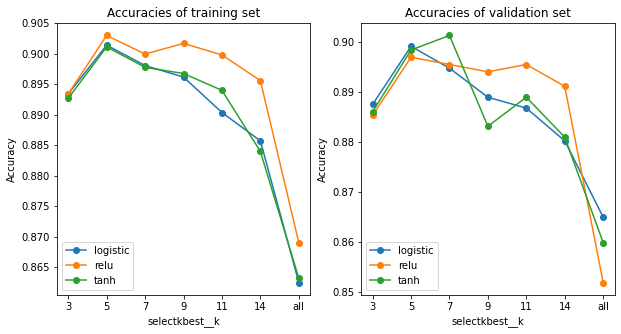

In [28]:
def plot_grid_search(grid_search, grid_params, attribute='mean_test_score', title='None'):
    scores = np.array(grid_search.cv_results_[attribute]).reshape(len(grid_params[list(grid_params.keys())[0]]), len(grid_params[list(grid_params.keys())[1]]))
    for score, param in zip(scores, grid_params[list(grid_params.keys())[0]]):
        plt.plot(grid_params[list(grid_params.keys())[1]], score, '-o', label=param)
    plt.legend(loc='lower left')
    plt.xlabel(list(grid_params.keys())[1])
    plt.ylabel('Accuracy')
    plt.title(title)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  
plot_grid_search(grid_search_mlp, param_grid_mlp, title='Accuracies of training set')
plt.subplot(1, 2, 2)
plot_grid_search(grid_search_mlp, param_grid_mlp, attribute='split2_test_score', title='Accuracies of validation set')

After using grid search for innovating model, we defined that the best activation was RELU and the number of features should be kept was 7 features. In which the accuracy was converging at **90.9%**

In [29]:
val_acc = grid_search_mlp.score(val_X_df, val_y_sr)*100
final_score = accuracy_score(grid_search_mlp.predict(test_X_df), test_y_sr, normalize=True)
print(f'With the grid searching, we found a better validate accuracy for the model with {val_acc.round(3)}%')
print(f'In conclusion, along with paramas of {grid_search_mlp.best_params_} we get the final test score in model be {final_score.round(3)}% in practical')

With the grid searching, we found a better validate accuracy for the model with 91.176%
In conclusion, along with paramas of {'mlpclassifier__activation': 'relu', 'selectkbest__k': 5} we get the final test score in model be 0.894% in practical


<h3>2nd Model: Classification using decision tree</h3>

Pipline architecture: Along including Preprocessing Pipeline, there are 2 more:
- `Selecting Best Features`: in this step, data would filtered in order to reduce the dimension of data by using `Chi2-Algorithms`. The number of features kept would be defined by manually or by grid search later.
- `DecisionTreeClassifier`: using Decision Tree method for classifying data into TRUE and FALSE in the Revenue.

In [30]:
tree_pipeline = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('selectkbest', SelectKBest(chi2, k=7)),
    ('decisiontree', DecisionTreeClassifier(random_state=0, max_depth=10))
])
tree_pipeline

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('coladderdropper',
                                  ColAdderDropper(columns_list=['Month',
                                                                'OperatingSystems',
                                                                'Browser',
                                                                'Region',
                                                                'TrafficType'],
                                                  num_top_values_list=[10, 5, 8,
                                                                       9,
                                                                       11])),
                                 ('columntransformer',
                                  ColumnTransformer(transformers=[('simpleimputer',
                                                                   SimpleImputer(),
                                                                   Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Infor...
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   Index(['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType',
       'VisitorType', 'Weekend'],
      dtype='object'))])),
                                 ('standardscaler',
                                  StandardScaler(with_mean=False))])),
                ('selectkbest',
                 SelectKBest(k=7,
                             score_func=<function chi2 at 0x000002F9A20F27A0>)),
                ('decisiontree',
                 DecisionTreeClassifier(max_depth=10, random_state=0))])

In [31]:
tree_pipeline.fit(train_X_df, train_y_sr)
tree_pipeline.score(val_X_df, val_y_sr)*100

89.27335640138409

From the defined parameters of decision model, which including `max_depth` is 10 and `number of k feautre kept` is 7, we receive ACCURACY is **89.2%**

In [35]:
optimize_pipeline = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('selectkbest', SelectKBest(chi2)),
    ('decisiontree', DecisionTreeClassifier(random_state=0))
])

param_grid_tree = {'selectkbest__k': [3, 5, 7, 9, 13, 15],
                'decisiontree__max_depth': [5, 8, 10, 12, 15]}

grid_search_tree = GridSearchCV(tree_pipeline, param_grid_tree)
grid_search_tree.fit(train_X_df, train_y_sr)

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        Pipeline(steps=[('coladderdropper',
                                                         ColAdderDropper(columns_list=['Month',
                                                                                       'OperatingSystems',
                                                                                       'Browser',
                                                                                       'Region',
                                                                                       'TrafficType'],
                                                                         num_top_values_list=[10,
                                                                                              5,
                                                                                              8,
                                                                                              9,
                                                                                              11])),
                                                        ('columntransformer',
                                                         ColumnTransformer(transformers=[('simpleimputer',
                                                                                          SimpleImputer(),
                                                                                          Index(['Administrative', 'Administrative_Duration'...
                                                                                          Index(['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType',
       'VisitorType', 'Weekend'],
      dtype='object'))])),
                                                        ('standardscaler',
                                                         StandardScaler(with_mean=False))])),
                                       ('selectkbest',
                                        SelectKBest(k=7,
                                                    score_func=<function chi2 at 0x000002F9A20F27A0>)),
                                       ('decisiontree',
                                        DecisionTreeClassifier(max_depth=10,
                                                               random_state=0))]),
             param_grid={'decisiontree__max_depth': [5, 8, 10, 12, 15],
                         'selectkbest__k': [3, 5, 7, 9, 13, 15]})

In [39]:
grid_search_tree.score(val_X_df, val_y_sr)*100

91.82525951557093

After grid searching in the fields of `number k features kept` and `max depth`, we figure out the new better ACCURACY was ~ **92%**

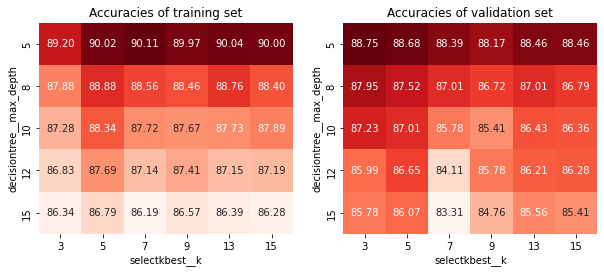

In [33]:
def plot_grid_search_heatmap(grid_search, grid_params, attribute='mean_test_score', title='None'):
    scores = np.array(grid_search.cv_results_[attribute]*100).reshape(5,6)
    df_heatmap = pd.DataFrame(scores, columns=grid_params[list(grid_params.keys())[0]], index=param_grid_tree[list(param_grid_tree.keys())[1]])
    sns.heatmap(df_heatmap, square=True, annot=True, cbar=False, fmt='.2f', cmap='Reds')
    plt.title(title)
    plt.xlabel(list(grid_params.keys())[0])
    plt.ylabel(list(grid_params.keys())[1])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1) 
plot_grid_search_heatmap(grid_search_tree, param_grid_tree, title='Accuracies of training set')
plt.subplot(1, 2, 2)
plot_grid_search_heatmap(grid_search_tree, param_grid_tree, attribute='split0_test_score', title='Accuracies of validation set')

In [40]:
accuracy_score(grid_search_tree.predict(test_X_df), test_y_sr)*100

89.16639636717483